# Chlorophyll vs MODIS Aqua (Masking SPECTRA's chlorophyll to only show output where there are observations at MODIS Aqua, and then compare with SeaWiFS as well)

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Seasonality in both SPECTRA and SeaWIFS throughout the Arctic

In [5]:
obsfiles_regrid = sorted(glob.glob('/glade/scratch/gabyn/SeaWiFS/regrid_chl_ocx_SeaWiFS.*.nc', recursive=True),
                      key=numericalSort)
obss = xr.open_mfdataset(obsfiles_regrid,concat_dim='time',combine='nested')

In [6]:
diat1_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diat1Chl.*.nc', recursive=True))
diat1_ds = xr.open_mfdataset(diat1_inds,combine='by_coords')

diat2_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diat2Chl.*.nc', recursive=True))
diat2_ds = xr.open_mfdataset(diat2_inds,combine='by_coords')

diat3_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diat3Chl.*.nc', recursive=True))
diat3_ds = xr.open_mfdataset(diat3_inds,combine='by_coords')

mp1_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp1Chl.*.nc', recursive=True))
mp1_ds = xr.open_mfdataset(mp1_inds,combine='by_coords')

mp2_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp2Chl.*.nc', recursive=True))
mp2_ds = xr.open_mfdataset(mp2_inds,combine='by_coords')

mp3_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp3Chl.*.nc', recursive=True))
mp3_ds = xr.open_mfdataset(mp3_inds,combine='by_coords')

mp4_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp4Chl.*.nc', recursive=True))
mp4_ds = xr.open_mfdataset(mp4_inds,combine='by_coords')

pp_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_ppChl.*.nc', recursive=True))
pp_ds = xr.open_mfdataset(pp_inds,combine='by_coords')

diaz_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diazChl.*.nc', recursive=True))
diaz_ds = xr.open_mfdataset(diaz_inds,combine='by_coords')

In [7]:
# MODIS Aqua (This is annually from 2003-2018). There are no monthly files here yet! 
obsfiles_regrid_MODIS = sorted(glob.glob('/glade/scratch/gabyn/MODIS_Aqua/mapped_monrhtly_climatology_regridded/regrid_MODIS_Aqua_chl_ocx_*.nc', recursive=True),
                      key=numericalSort)
obss_MODIS = xr.open_mfdataset(obsfiles_regrid_MODIS,concat_dim='time',combine='nested')

In [8]:
obss_MODIS.chl_ocx.shape

(12, 180, 360)

In [9]:
phytoChl = np.stack([pp_ds.ppChl, mp1_ds.mp1Chl, diaz_ds.diazChl, 
                               diat1_ds.diat1Chl, mp2_ds.mp2Chl, diat2_ds.diat2Chl, 
                               mp3_ds.mp3Chl, diat3_ds.diat3Chl, mp4_ds.mp4Chl])
# This is if you want to add the chl from all phytoplankton and also all of the depths! 
#phytoChl = np.nansum(phytoChl, axis =(0,2))

# Depth integrated top 50 m 
phytoChl_50m = np.nansum(phytoChl[:,:,0:5,:,:], axis =(0,2))*10/50 

# Surface Chl. 
phytoChl_surface = np.nansum(phytoChl[:,:,0,:,:], axis =0) 

## Plot SPECTRA, SeaWIFS and MODIS how they are annually!! 

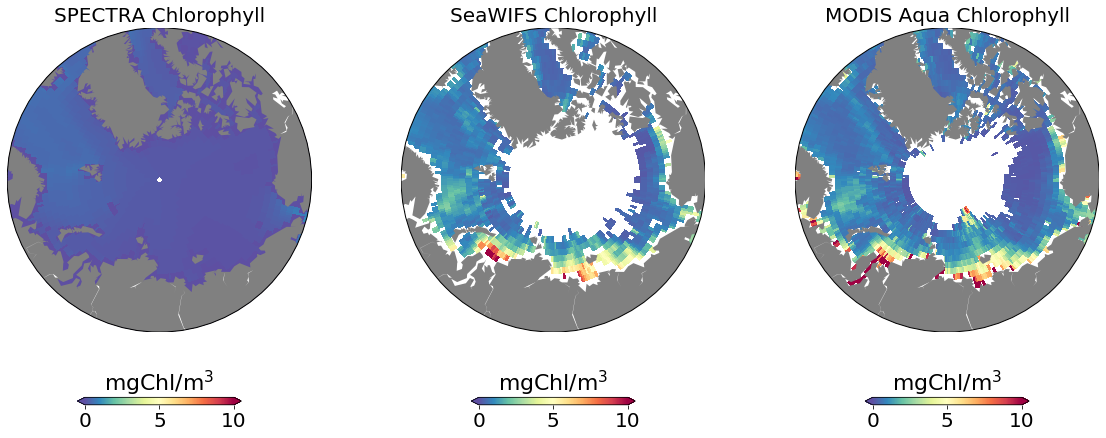

In [12]:
fig = plt.figure(figsize=(20, 8));

ax = fig.add_subplot(1, 3, 1);
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c');
m.fillcontinents(color='gray');

chl, lon = add_cyclic_point(np.nanmean(phytoChl_surface, axis=0), coord=obss.lon, axis=1);
x, y = m(*np.meshgrid(lon,obss.lat));
cf = m.pcolor(x,y,chl,cmap='Spectral_r',vmin=0,vmax=10);
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both');
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22);
cb.ax.tick_params(labelsize=20);
ax.set_title('SPECTRA Chlorophyll', fontsize =20);

ax = fig.add_subplot(1, 3, 2);
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c');
m.fillcontinents(color='gray');

chlo, lon = add_cyclic_point(np.nanmean(obss.chl_ocx, axis=0), coord=obss.lon, axis=1);
x, y = m(*np.meshgrid(lon,obss.lat));
cf = m.pcolor(x,y,chlo,cmap='Spectral_r',vmin=0,vmax=10);
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both');
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22);
cb.ax.tick_params(labelsize=20);
ax.set_title('SeaWIFS Chlorophyll', fontsize =20);

ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c');
m.fillcontinents(color='gray');

chlo2, lon = add_cyclic_point(np.nanmean(obss_MODIS.chl_ocx, axis=0), coord=obss.lon, axis=1);
x, y = m(*np.meshgrid(lon,obss.lat));
cf = m.pcolor(x,y,chlo2,cmap='Spectral_r',vmin=0,vmax=10);
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both');
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22);
cb.ax.tick_params(labelsize=20);
ax.set_title('MODIS Aqua Chlorophyll', fontsize =20);

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chla_AO_annual_SPECTRA_SeaWiFS_MODIS.png',dpi=600, bbox_inches='tight')

## Plot difference between SeaWiFS and MODIS Aqua

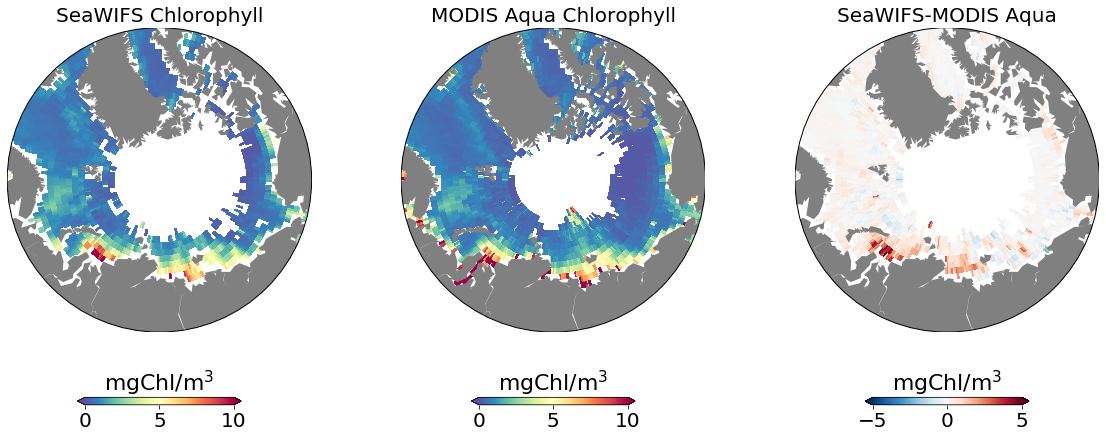

In [13]:
fig = plt.figure(figsize=(20, 8));

ax = fig.add_subplot(1, 3, 1);
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c');
m.fillcontinents(color='gray');

chlo, lon = add_cyclic_point(np.nanmean(obss.chl_ocx, axis=0), coord=obss.lon, axis=1);
x, y = m(*np.meshgrid(lon,obss.lat));
cf = m.pcolor(x,y,chlo,cmap='Spectral_r',vmin=0,vmax=10);
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both');
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22);
cb.ax.tick_params(labelsize=20);
ax.set_title('SeaWIFS Chlorophyll', fontsize =20);

ax = fig.add_subplot(1, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c');
m.fillcontinents(color='gray');

chlo2, lon = add_cyclic_point(np.nanmean(obss_MODIS.chl_ocx, axis=0), coord=obss.lon, axis=1);
x, y = m(*np.meshgrid(lon,obss.lat));
cf = m.pcolor(x,y,chlo2,cmap='Spectral_r',vmin=0,vmax=10);
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both');
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22);
cb.ax.tick_params(labelsize=20);
ax.set_title('MODIS Aqua Chlorophyll', fontsize =20);

ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c');
m.fillcontinents(color='gray');
cf = m.pcolor(x,y,(chlo-chlo2),cmap='RdBu_r', vmin = -5, vmax = 5);
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both');
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22);
cb.ax.tick_params(labelsize=20);
ax.set_title('SeaWIFS-MODIS Aqua', fontsize =20);


fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chla_AO_annual_SeaWiFS_vs_MODIS.png',dpi=600, bbox_inches='tight')

In [10]:
ind_data_01 = np.isnan(obss.chl_ocx[0,:,:])
ind_data_02 = np.isnan(obss.chl_ocx[1,:,:])
ind_data_03 = np.isnan(obss.chl_ocx[2,:,:])
ind_data_04 = np.isnan(obss.chl_ocx[3,:,:])
ind_data_05 = np.isnan(obss.chl_ocx[4,:,:])
ind_data_06 = np.isnan(obss.chl_ocx[5,:,:])
ind_data_07 = np.isnan(obss.chl_ocx[6,:,:])
ind_data_08 = np.isnan(obss.chl_ocx[7,:,:])
ind_data_09 = np.isnan(obss.chl_ocx[8,:,:])
ind_data_10 = np.isnan(obss.chl_ocx[9,:,:])
ind_data_11 = np.isnan(obss.chl_ocx[10,:,:])
ind_data_12 = np.isnan(obss.chl_ocx[11,:,:])

In [11]:
# this makes the values that are NaN on the obs to NaN in SPECTRA
phytoChl_50m[0,ind_data_01] = np.nan 
phytoChl_50m[1,ind_data_02] = np.nan
phytoChl_50m[2,ind_data_03] = np.nan
phytoChl_50m[3,ind_data_04] = np.nan
phytoChl_50m[4,ind_data_05] = np.nan
phytoChl_50m[5,ind_data_06] = np.nan
phytoChl_50m[6,ind_data_07] = np.nan
phytoChl_50m[7,ind_data_08] = np.nan
phytoChl_50m[8,ind_data_09] = np.nan
phytoChl_50m[9,ind_data_10] = np.nan
phytoChl_50m[10,ind_data_11] = np.nan
phytoChl_50m[11,ind_data_12] = np.nan

# NOW FOR THE SURFACE
phytoChl_surface[0,ind_data_01] = np.nan 
phytoChl_surface[1,ind_data_02] = np.nan
phytoChl_surface[2,ind_data_03] = np.nan
phytoChl_surface[3,ind_data_04] = np.nan
phytoChl_surface[4,ind_data_05] = np.nan
phytoChl_surface[5,ind_data_06] = np.nan
phytoChl_surface[6,ind_data_07] = np.nan
phytoChl_surface[7,ind_data_08] = np.nan
phytoChl_surface[8,ind_data_09] = np.nan
phytoChl_surface[9,ind_data_10] = np.nan
phytoChl_surface[10,ind_data_11] = np.nan
phytoChl_surface[11,ind_data_12] = np.nan

In [12]:
# Model Chlorophyll for every region (surface)
model_ao = np.nanmean(phytoChl_surface[:,170:180,:], axis=(1,2))
model_cs = np.nanmean(phytoChl_surface[:,149:170,0:25], axis = (1,2))
model_bs = np.nanmean(phytoChl_surface[:,149:170,25:55], axis = (1,2))
model_ca = np.nanmean(phytoChl_surface[:,149:170,55:110], axis = (1,2))
model_bb = np.nanmean(phytoChl_surface[:,149:170,110:135], axis = (1,2))
model_ess = np.nanmean(phytoChl_surface[:,149:170,325:360], axis = (1,2))
model_ls = np.nanmean(phytoChl_surface[:,149:170,270:325], axis = (1,2))
model_ns = np.nanmean(phytoChl_surface[:,149:170,155:205], axis = (1,2))
model_bts =np.nanmean(phytoChl_surface[:,149:170,205:233], axis = (1,2))
model_ks = np.nanmean(phytoChl_surface[:,149:170,233:270], axis = (1,2))

# Top 50 meters
model_ao_50m = np.nanmean(phytoChl_50m[:,170:180,:], axis=(1,2))
model_cs_50m = np.nanmean(phytoChl_50m[:,149:170,0:25], axis = (1,2))
model_bs_50m = np.nanmean(phytoChl_50m[:,149:170,25:55], axis = (1,2))
model_ca_50m = np.nanmean(phytoChl_50m[:,149:170,55:110], axis = (1,2))
model_bb_50m = np.nanmean(phytoChl_50m[:,149:170,110:135], axis = (1,2))
model_ess_50m = np.nanmean(phytoChl_50m[:,149:170,325:360], axis = (1,2))
model_ls_50m = np.nanmean(phytoChl_50m[:,149:170,270:325], axis = (1,2))
model_ns_50m = np.nanmean(phytoChl_50m[:,149:170,155:205], axis = (1,2))
model_bts_50m =np.nanmean(phytoChl_50m[:,149:170,205:233], axis = (1,2))
model_ks_50m = np.nanmean(phytoChl_50m[:,149:170,233:270], axis = (1,2))

# Observed Chlorophyll for every region. 
obs_ao = np.nanmean(obss.chl_ocx[:,170:180,:], axis=(1,2))
obs_cs = np.nanmean(obss.chl_ocx[:,149:170,0:25], axis = (1,2))
obs_bs = np.nanmean(obss.chl_ocx[:,149:170,25:55], axis = (1,2))
obs_ca = np.nanmean(obss.chl_ocx[:,149:170,55:110], axis = (1,2))
obs_bb = np.nanmean(obss.chl_ocx[:,149:170,110:135], axis = (1,2))
obs_ess = np.nanmean(obss.chl_ocx[:,149:170,325:360], axis = (1,2))
obs_ls = np.nanmean(obss.chl_ocx[:,149:170,270:325], axis = (1,2))
obs_ns = np.nanmean(obss.chl_ocx[:,149:170,155:205], axis = (1,2))
obs_bts =np.nanmean(obss.chl_ocx[:,149:170,205:233], axis = (1,2))
obs_ks = np.nanmean(obss.chl_ocx[:,149:170,233:270], axis = (1,2))

# MODIS Aqua chlorophyll 
modis_ao = np.nanmean(obss_MODIS.chl_ocx[:,170:180,:], axis=(1,2))
modis_cs = np.nanmean(obss_MODIS.chl_ocx[:,149:170,0:25], axis = (1,2))
modis_bs = np.nanmean(obss_MODIS.chl_ocx[:,149:170,25:55], axis = (1,2))
modis_ca = np.nanmean(obss_MODIS.chl_ocx[:,149:170,55:110], axis = (1,2))
modis_bb = np.nanmean(obss_MODIS.chl_ocx[:,149:170,110:135], axis = (1,2))
modis_ess = np.nanmean(obss_MODIS.chl_ocx[:,149:170,325:360], axis = (1,2))
modis_ls = np.nanmean(obss_MODIS.chl_ocx[:,149:170,270:325], axis = (1,2))
modis_ns = np.nanmean(obss_MODIS.chl_ocx[:,149:170,155:205], axis = (1,2))
modis_bts =np.nanmean(obss_MODIS.chl_ocx[:,149:170,205:233], axis = (1,2))
modis_ks = np.nanmean(obss_MODIS.chl_ocx[:,149:170,233:270], axis = (1,2))

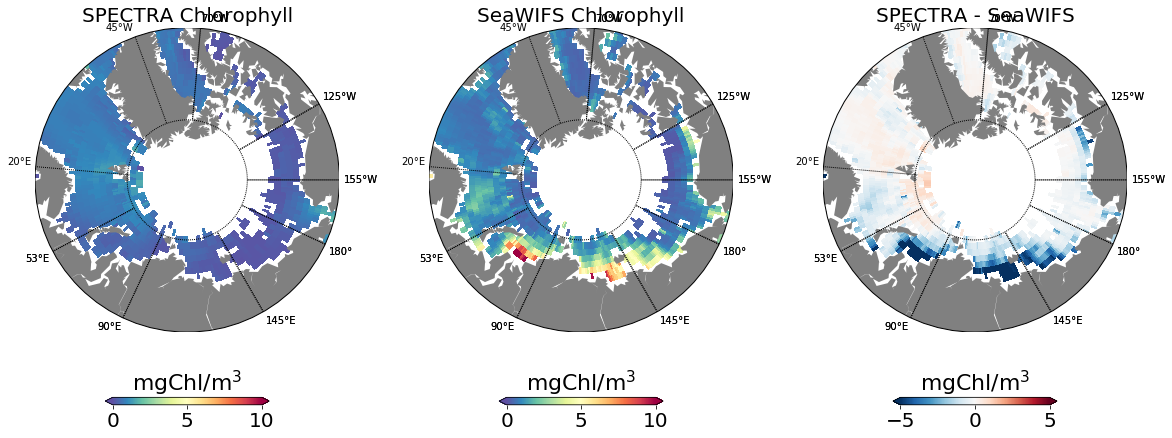

In [75]:
fig = plt.figure(figsize=(20, 8));

ax = fig.add_subplot(1, 3, 1);
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c');
m.fillcontinents(color='gray');

chl, lon = add_cyclic_point(np.nanmean(phytoChl_surface, axis=0), coord=obss.lon, axis=1);
x, y = m(*np.meshgrid(lon,obss.lat));
cf = m.pcolor(x,y,chl,cmap='Spectral_r',vmin=0,vmax=10);
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both');
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22);
cb.ax.tick_params(labelsize=20);
ax.set_title('SPECTRA Chlorophyll', fontsize =20);

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0]);

ax = fig.add_subplot(1, 3, 2);
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c');
m.fillcontinents(color='gray');

chlo, lon = add_cyclic_point(np.nanmean(obss.chl_ocx, axis=0), coord=obss.lon, axis=1);
x, y = m(*np.meshgrid(lon,obss.lat));
cf = m.pcolor(x,y,chlo,cmap='Spectral_r',vmin=0,vmax=10);
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both');
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22);
cb.ax.tick_params(labelsize=20);
ax.set_title('SeaWIFS Chlorophyll', fontsize =20);

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0]);

ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c');
m.fillcontinents(color='gray');
cf = m.pcolor(x,y,(chl-chlo),cmap='RdBu_r', vmin = -5, vmax = 5);
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both');
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22);
cb.ax.tick_params(labelsize=20);
ax.set_title('SPECTRA - SeaWIFS', fontsize =20);

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0]);
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chla_AO_annual_comparison_20yrclim_remap_nonlog.png',dpi=600, bbox_inches='tight')

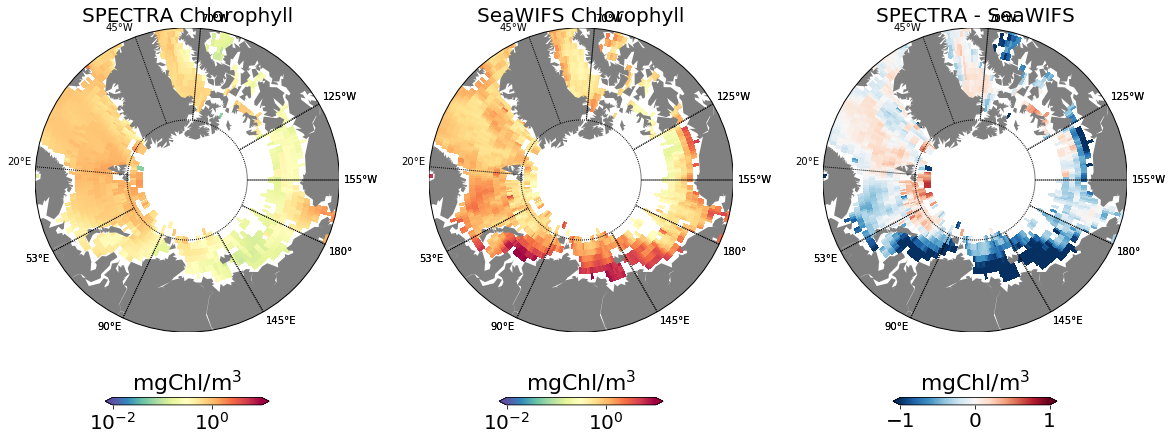

In [76]:
fig = plt.figure(figsize=(20, 8));

ax = fig.add_subplot(1, 3, 1);
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c');
m.fillcontinents(color='gray');

chl, lon = add_cyclic_point(np.nanmean(phytoChl_surface, axis=0), coord=obss.lon, axis=1);
x, y = m(*np.meshgrid(lon,obss.lat));
cf = m.pcolor(x,y,chl,cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both');
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22);
cb.ax.tick_params(labelsize=20);
ax.set_title('SPECTRA Chlorophyll', fontsize =20);

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0]);

ax = fig.add_subplot(1, 3, 2);
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c');
m.fillcontinents(color='gray');

chlo, lon = add_cyclic_point(np.nanmean(obss.chl_ocx, axis=0), coord=obss.lon, axis=1);
x, y = m(*np.meshgrid(lon,obss.lat));
cf = m.pcolor(x,y,chlo,cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both');
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22);
cb.ax.tick_params(labelsize=20);
ax.set_title('SeaWIFS Chlorophyll', fontsize =20);

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0]);

ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c');
m.fillcontinents(color='gray');
cf = m.pcolor(x,y,(np.log10(chl)-np.log10(chlo)),cmap='RdBu_r', vmin = -1, vmax = 1);
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both');
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22);
cb.ax.tick_params(labelsize=20);
ax.set_title('SPECTRA - SeaWIFS', fontsize =20);

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0]);
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chla_AO_annual_comparison_20yrclim_remap_log10.png',dpi=600, bbox_inches='tight')

## Make some of the plots with MODIS Now 

In [13]:
phytoChl = np.stack([pp_ds.ppChl, mp1_ds.mp1Chl, diaz_ds.diazChl, 
                               diat1_ds.diat1Chl, mp2_ds.mp2Chl, diat2_ds.diat2Chl, 
                               mp3_ds.mp3Chl, diat3_ds.diat3Chl, mp4_ds.mp4Chl])

# Depth integrated top 50 m 
phytoChl_50m_modis = np.nansum(phytoChl[:,:,0:5,:,:], axis =(0,2))*10/50 

# Surface Chl. 
phytoChl_surface_modis = np.nansum(phytoChl[:,:,0,:,:], axis =0) 

ind_data_01 = np.isnan(obss_MODIS.chl_ocx[0,:,:])
ind_data_02 = np.isnan(obss_MODIS.chl_ocx[1,:,:])
ind_data_03 = np.isnan(obss_MODIS.chl_ocx[2,:,:])
ind_data_04 = np.isnan(obss_MODIS.chl_ocx[3,:,:])
ind_data_05 = np.isnan(obss_MODIS.chl_ocx[4,:,:])
ind_data_06 = np.isnan(obss_MODIS.chl_ocx[5,:,:])
ind_data_07 = np.isnan(obss_MODIS.chl_ocx[6,:,:])
ind_data_08 = np.isnan(obss_MODIS.chl_ocx[7,:,:])
ind_data_09 = np.isnan(obss_MODIS.chl_ocx[8,:,:])
ind_data_10 = np.isnan(obss_MODIS.chl_ocx[9,:,:])
ind_data_11 = np.isnan(obss_MODIS.chl_ocx[10,:,:])
ind_data_12 = np.isnan(obss_MODIS.chl_ocx[11,:,:])

# this makes the values that are NaN on the obs to NaN in SPECTRA
phytoChl_50m_modis[0,ind_data_01] = np.nan 
phytoChl_50m_modis[1,ind_data_02] = np.nan
phytoChl_50m_modis[2,ind_data_03] = np.nan
phytoChl_50m_modis[3,ind_data_04] = np.nan
phytoChl_50m_modis[4,ind_data_05] = np.nan
phytoChl_50m_modis[5,ind_data_06] = np.nan
phytoChl_50m_modis[6,ind_data_07] = np.nan
phytoChl_50m_modis[7,ind_data_08] = np.nan
phytoChl_50m_modis[8,ind_data_09] = np.nan
phytoChl_50m_modis[9,ind_data_10] = np.nan
phytoChl_50m_modis[10,ind_data_11] = np.nan
phytoChl_50m_modis[11,ind_data_12] = np.nan

# NOW FOR THE SURFACE
phytoChl_surface_modis[0,ind_data_01] = np.nan 
phytoChl_surface_modis[1,ind_data_02] = np.nan
phytoChl_surface_modis[2,ind_data_03] = np.nan
phytoChl_surface_modis[3,ind_data_04] = np.nan
phytoChl_surface_modis[4,ind_data_05] = np.nan
phytoChl_surface_modis[5,ind_data_06] = np.nan
phytoChl_surface_modis[6,ind_data_07] = np.nan
phytoChl_surface_modis[7,ind_data_08] = np.nan
phytoChl_surface_modis[8,ind_data_09] = np.nan
phytoChl_surface_modis[9,ind_data_10] = np.nan
phytoChl_surface_modis[10,ind_data_11] = np.nan
phytoChl_surface_modis[11,ind_data_12] = np.nan

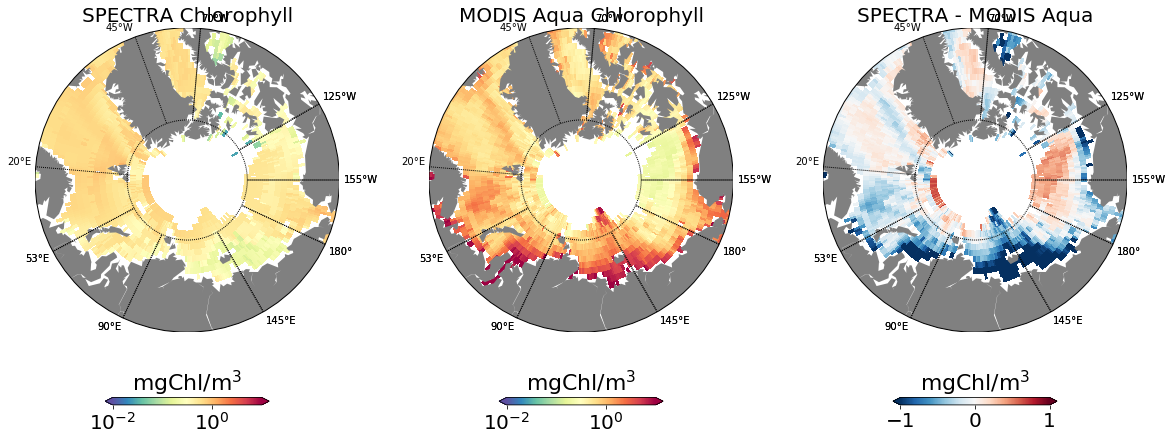

In [18]:
fig = plt.figure(figsize=(20, 8));

ax = fig.add_subplot(1, 3, 1);
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c');
m.fillcontinents(color='gray');

chl, lon = add_cyclic_point(np.nanmean(phytoChl_50m_modis, axis=0), coord=obss.lon, axis=1);
x, y = m(*np.meshgrid(lon,obss.lat));
cf = m.pcolor(x,y,chl,cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both');
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22);
cb.ax.tick_params(labelsize=20);
ax.set_title('SPECTRA Chlorophyll', fontsize =20);

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0]);

ax = fig.add_subplot(1, 3, 2);
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c');
m.fillcontinents(color='gray');

chlo, lon = add_cyclic_point(np.nanmean(obss_MODIS.chl_ocx, axis=0), coord=obss.lon, axis=1);
x, y = m(*np.meshgrid(lon,obss.lat));
cf = m.pcolor(x,y,chlo,cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both');
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22);
cb.ax.tick_params(labelsize=20);
ax.set_title('MODIS Aqua Chlorophyll', fontsize =20);

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0]);

ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c');
m.fillcontinents(color='gray');
cf = m.pcolor(x,y,(np.log10(chl)-np.log10(chlo)),cmap='RdBu_r', vmin = -1, vmax = 1);
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both');
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22);
cb.ax.tick_params(labelsize=20);
ax.set_title('SPECTRA - MODIS Aqua', fontsize =20);

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0]);
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chla_AO_annual_comparison_MODIS_20yrclim_remap_log10.png',dpi=600, bbox_inches='tight')

In [19]:
# This is the error on the observations
err_ao = np.nanstd(obs_ao)
err_cs = np.nanstd(obs_cs)
err_bs = np.nanstd(obs_bs)
err_ca = np.nanstd(obs_ca)
err_bb = np.nanstd(obs_bb)
err_ess = np.nanstd(obs_ess)
err_ls = np.nanstd(obs_ls)
err_ns = np.nanstd(obs_ns)
err_bts = np.nanstd(obs_bts)
err_ks = np.nanstd(obs_ks)

# This is the error on the observations
err_ao_modis = np.nanstd(modis_ao)
err_cs_modis = np.nanstd(modis_cs)
err_bs_modis = np.nanstd(modis_bs)
err_ca_modis = np.nanstd(modis_ca)
err_bb_modis = np.nanstd(modis_bb)
err_ess_modis = np.nanstd(modis_ess)
err_ls_modis = np.nanstd(modis_ls)
err_ns_modis = np.nanstd(modis_ns)
err_bts_modis = np.nanstd(modis_bts)
err_ks_modis = np.nanstd(modis_ks)

# This is the error on the model
err_aom = np.nanstd(model_ao)
err_csm = np.nanstd(model_cs)
err_bsm = np.nanstd(model_bs)
err_cam = np.nanstd(model_ca)
err_bbm = np.nanstd(model_bb)
err_essm = np.nanstd(model_ess)
err_lsm = np.nanstd(model_ls)
err_nsm = np.nanstd(model_ns)
err_btsm = np.nanstd(model_bts)
err_ksm = np.nanstd(model_ks)

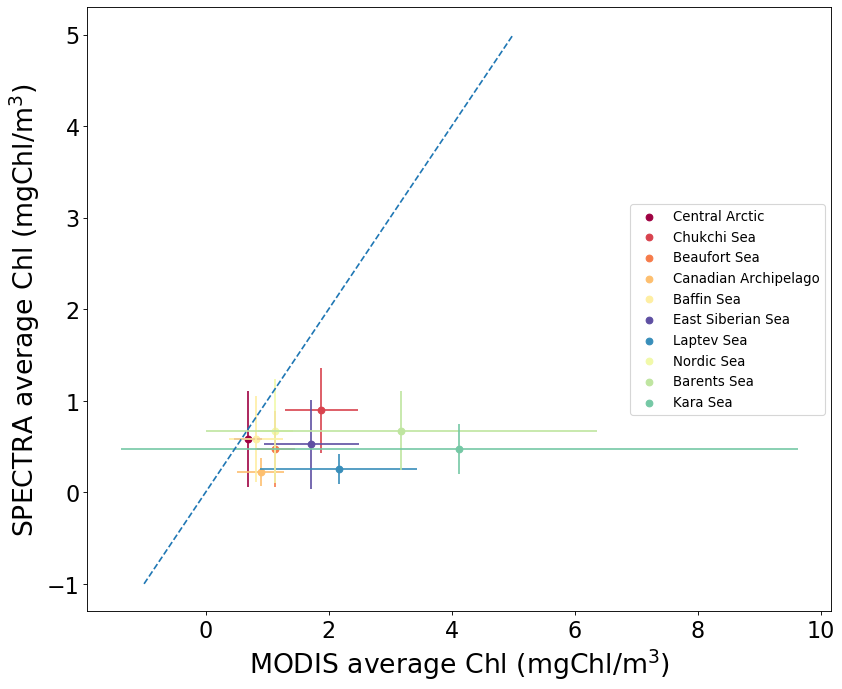

In [22]:
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

cmap=matplotlib.cm.get_cmap('Spectral', 10)

plt.scatter(np.nanmean(modis_ao),np.nanmean(model_ao),color=cmap(0),label='Central Arctic')
plt.errorbar(np.nanmean(modis_ao),np.nanmean(model_ao),yerr=err_aom,xerr=err_ao_modis, color=cmap(0),linestyle="None")

plt.scatter(np.nanmean(modis_cs),np.nanmean(model_cs),color=cmap(1),label='Chukchi Sea')
plt.errorbar(np.nanmean(modis_cs),np.nanmean(model_cs),yerr=err_csm,xerr=err_cs_modis, color=cmap(1),linestyle="None")

plt.scatter(np.nanmean(modis_bs),np.nanmean(model_bs), color=cmap(2),label='Beaufort Sea')
plt.errorbar(np.nanmean(modis_bs),np.nanmean(model_bs),yerr=err_bsm,xerr=err_bs_modis, color=cmap(2),linestyle="None")

plt.scatter(np.nanmean(modis_ca),np.nanmean(model_ca), color=cmap(3),label='Canadian Archipelago')
plt.errorbar(np.nanmean(modis_ca),np.nanmean(model_ca),yerr=err_cam,xerr=err_ca_modis, color=cmap(3),linestyle="None")

plt.scatter(np.nanmean(modis_bb),np.nanmean(model_bb), color=cmap(4),label='Baffin Sea')
plt.errorbar(np.nanmean(modis_bb),np.nanmean(model_bb),yerr=err_bbm,xerr=err_bb_modis, color=cmap(4),linestyle="None")

plt.scatter(np.nanmean(modis_ess),np.nanmean(model_ess), color=cmap(9),label='East Siberian Sea')
plt.errorbar(np.nanmean(modis_ess),np.nanmean(model_ess),yerr=err_essm,xerr=err_ess_modis, color=cmap(9),linestyle="None")

plt.scatter(np.nanmean(modis_ls),np.nanmean(model_ls),color=cmap(8),label='Laptev Sea')
plt.errorbar(np.nanmean(modis_ls),np.nanmean(model_ls),yerr=err_lsm,xerr=err_ls_modis, color=cmap(8),linestyle="None")

plt.scatter(np.nanmean(modis_ns),np.nanmean(model_ns), color=cmap(5),label='Nordic Sea')
plt.errorbar(np.nanmean(modis_ns),np.nanmean(model_ns),yerr=err_nsm,xerr=err_ns_modis, color=cmap(5),linestyle="None")

plt.scatter(np.nanmean(modis_bts),np.nanmean(model_bts), color=cmap(6),label='Barents Sea')
plt.errorbar(np.nanmean(modis_bts),np.nanmean(model_bts),yerr=err_btsm,xerr=err_bts_modis, color=cmap(6),linestyle="None")

plt.scatter(np.nanmean(modis_ks),np.nanmean(model_ks), color=cmap(7),label='Kara Sea')
plt.errorbar(np.nanmean(modis_ks),np.nanmean(model_ks),yerr=err_ksm,xerr=err_ks_modis, color=cmap(7),linestyle="None")

plt.plot([-1,0,1,2,3,4,5], [-1,0,1,2,3,4,5], '--')

plt.legend(loc='center right', fontsize=12)
plt.ylabel('SPECTRA average Chl ($mg Chl$/$m^3$)', fontsize=24)
plt.xlabel('MODIS average Chl ($mg Chl$/$m^3$)', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)

plt.show()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_MODIS_scatter_remap_.png', dpi=600, bbox_inches='tight')

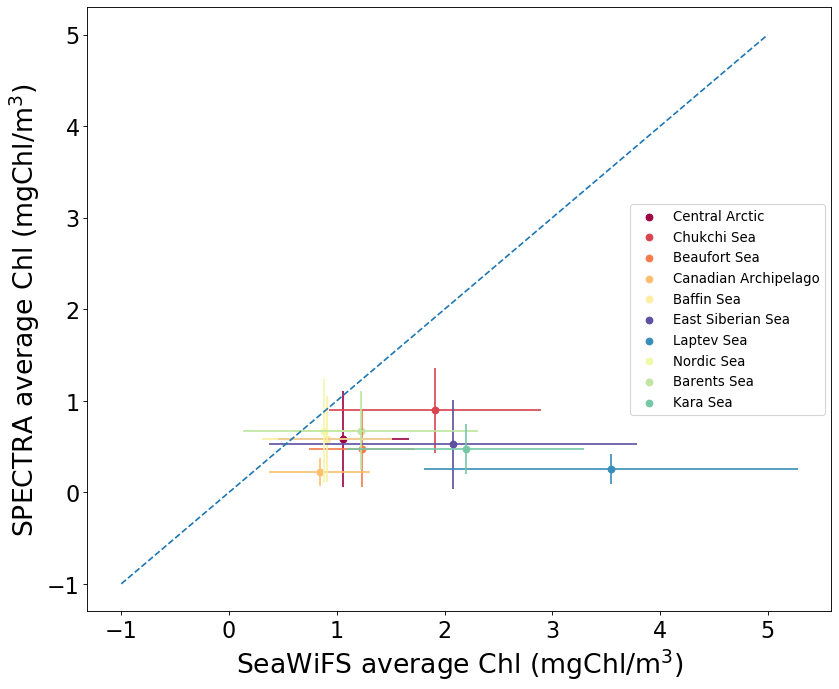

In [79]:
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

cmap=matplotlib.cm.get_cmap('Spectral', 10)

plt.scatter(np.nanmean(obs_ao),np.nanmean(model_ao),color=cmap(0),label='Central Arctic')
plt.errorbar(np.nanmean(obs_ao),np.nanmean(model_ao),yerr=err_aom,xerr=err_ao, color=cmap(0),linestyle="None")

plt.scatter(np.nanmean(obs_cs),np.nanmean(model_cs),color=cmap(1),label='Chukchi Sea')
plt.errorbar(np.nanmean(obs_cs),np.nanmean(model_cs),yerr=err_csm,xerr=err_cs, color=cmap(1),linestyle="None")

plt.scatter(np.nanmean(obs_bs),np.nanmean(model_bs), color=cmap(2),label='Beaufort Sea')
plt.errorbar(np.nanmean(obs_bs),np.nanmean(model_bs),yerr=err_bsm,xerr=err_bs, color=cmap(2),linestyle="None")

plt.scatter(np.nanmean(obs_ca),np.nanmean(model_ca), color=cmap(3),label='Canadian Archipelago')
plt.errorbar(np.nanmean(obs_ca),np.nanmean(model_ca),yerr=err_cam,xerr=err_ca, color=cmap(3),linestyle="None")

plt.scatter(np.nanmean(obs_bb),np.nanmean(model_bb), color=cmap(4),label='Baffin Sea')
plt.errorbar(np.nanmean(obs_bb),np.nanmean(model_bb),yerr=err_bbm,xerr=err_bb, color=cmap(4),linestyle="None")

plt.scatter(np.nanmean(obs_ess),np.nanmean(model_ess), color=cmap(9),label='East Siberian Sea')
plt.errorbar(np.nanmean(obs_ess),np.nanmean(model_ess),yerr=err_essm,xerr=err_ess, color=cmap(9),linestyle="None")

plt.scatter(np.nanmean(obs_ls),np.nanmean(model_ls),color=cmap(8),label='Laptev Sea')
plt.errorbar(np.nanmean(obs_ls),np.nanmean(model_ls),yerr=err_lsm,xerr=err_ls, color=cmap(8),linestyle="None")

plt.scatter(np.nanmean(obs_ns),np.nanmean(model_ns), color=cmap(5),label='Nordic Sea')
plt.errorbar(np.nanmean(obs_ns),np.nanmean(model_ns),yerr=err_nsm,xerr=err_ns, color=cmap(5),linestyle="None")

plt.scatter(np.nanmean(obs_bts),np.nanmean(model_bts), color=cmap(6),label='Barents Sea')
plt.errorbar(np.nanmean(obs_bts),np.nanmean(model_bts),yerr=err_btsm,xerr=err_bts, color=cmap(6),linestyle="None")

plt.scatter(np.nanmean(obs_ks),np.nanmean(model_ks), color=cmap(7),label='Kara Sea')
plt.errorbar(np.nanmean(obs_ks),np.nanmean(model_ks),yerr=err_ksm,xerr=err_ks, color=cmap(7),linestyle="None")

plt.plot([-1,0,1,2,3,4,5], [-1,0,1,2,3,4,5], '--')

plt.legend(loc='center right', fontsize=12)
plt.ylabel('SPECTRA average Chl ($mg Chl$/$m^3$)', fontsize=24)
plt.xlabel('SeaWiFS average Chl ($mg Chl$/$m^3$)', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)

plt.show()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_SeaWIFS_scatter_remap_.png', dpi=600, bbox_inches='tight')

## Now check the seasonality

In [14]:
PAR_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_PAR_avg.*.nc', recursive=True))
PAR_ds = xr.open_mfdataset(PAR_inds,combine='by_coords')

ice_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_ECOSYS_IFRAC.*.nc', recursive=True))
ice_ds = xr.open_mfdataset(ice_inds,combine='by_coords')

In [15]:
# Model ice for every region 
ice_ao = np.nanmean(ice_ds.ECOSYS_IFRAC[:,170:180,:], axis=(1,2))
ice_cs = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,0:25], axis = (1,2))
ice_bs = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,25:55], axis = (1,2))
ice_ca = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,55:110], axis = (1,2))
ice_bb = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,110:135], axis = (1,2))
ice_ess = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,325:360], axis = (1,2))
ice_ls = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,270:325], axis = (1,2))
ice_ns = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,155:205], axis = (1,2))
ice_bts =np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,205:233], axis = (1,2))
ice_ks = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,233:270], axis = (1,2))


# Modeling the PAR average 
PAR_ao = np.nanmean(PAR_ds.PAR_avg[:,0,170:180,:], axis=(1,2))
PAR_cs = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,0:25], axis = (1,2))
PAR_bs = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,25:55], axis = (1,2))
PAR_ca = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,55:110], axis = (1,2))
PAR_bb = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,110:135], axis = (1,2))
PAR_ess = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,325:360], axis = (1,2))
PAR_ls = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,270:325], axis = (1,2))
PAR_ns = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,155:205], axis = (1,2))
PAR_bts =np.nanmean(PAR_ds.PAR_avg[:,0,149:170,205:233], axis = (1,2))
PAR_ks = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,233:270], axis = (1,2))

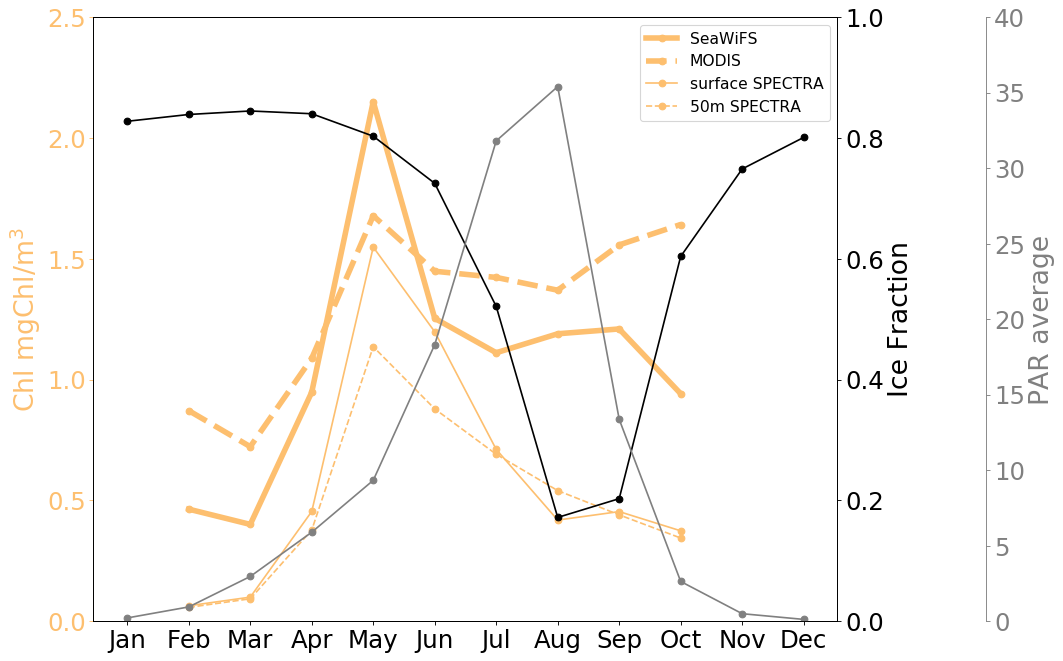

In [27]:
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:179, :],axis=(1,2)),'-o', color='k',label='Ice-Fraction')
ax3.plot(months, np.nanmean(PAR_ds.PAR_avg[:,0,149:179, :],axis=(1,2)),'-o', color='gray',label='PAR Average')
ax.plot(months,np.nanmean(obss.chl_ocx[:,149:179, :],axis=(1,2)), '-o', color=cmap(3),linewidth=5,label='SeaWiFS')
ax.plot(months,np.nanmean(obss_MODIS.chl_ocx[:,149:179, :],axis=(1,2)), '--o', color=cmap(3),linewidth=5,label='MODIS')
ax.plot(months,np.nanmean(phytoChl_surface[:,149:179, :], axis=(1,2)), '-o', color=cmap(3),label='surface SPECTRA')
ax.plot(months,np.nanmean(phytoChl_50m[:,149:179, :], axis=(1,2)), '--o', color=cmap(3),label='50m SPECTRA')
ax.set_ylim(0,2.5); ax2.set_ylim(0,1); ax3.set_ylim(0,40)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(3))  
ax.spines['left'].set_color(cmap(3)); ax.tick_params(axis='y', colors=cmap(3))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_SeaWIFS_MODIS_seasonality_remap.png', dpi=600, bbox_inches='tight')

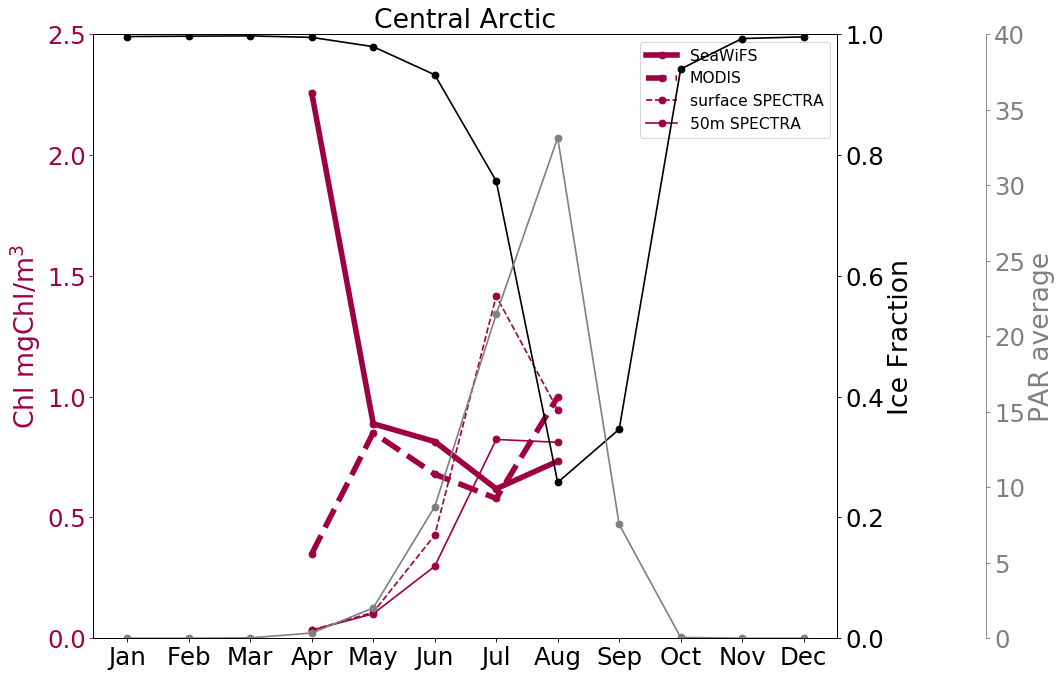

In [29]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ao, '-o', color=cmap(0),linewidth=5,label='SeaWiFS')
ax.plot(months,modis_ao, '--o', color=cmap(0),linewidth=5,label='MODIS')
ax.plot(months,model_ao, '--o', color=cmap(0),label='surface SPECTRA')
ax.plot(months,model_ao_50m, '-o', color=cmap(0),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Central Arctic', fontsize=24)

ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ao,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ao,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,2.5); ax2.set_ylim(0,1); ax3.set_ylim(0,40)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(0))  
ax.spines['left'].set_color(cmap(0)); ax.tick_params(axis='y', colors=cmap(0))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_SeaWIFS_MODIS_CentralArctic_seasonality_remap.png', dpi=600, bbox_inches='tight')

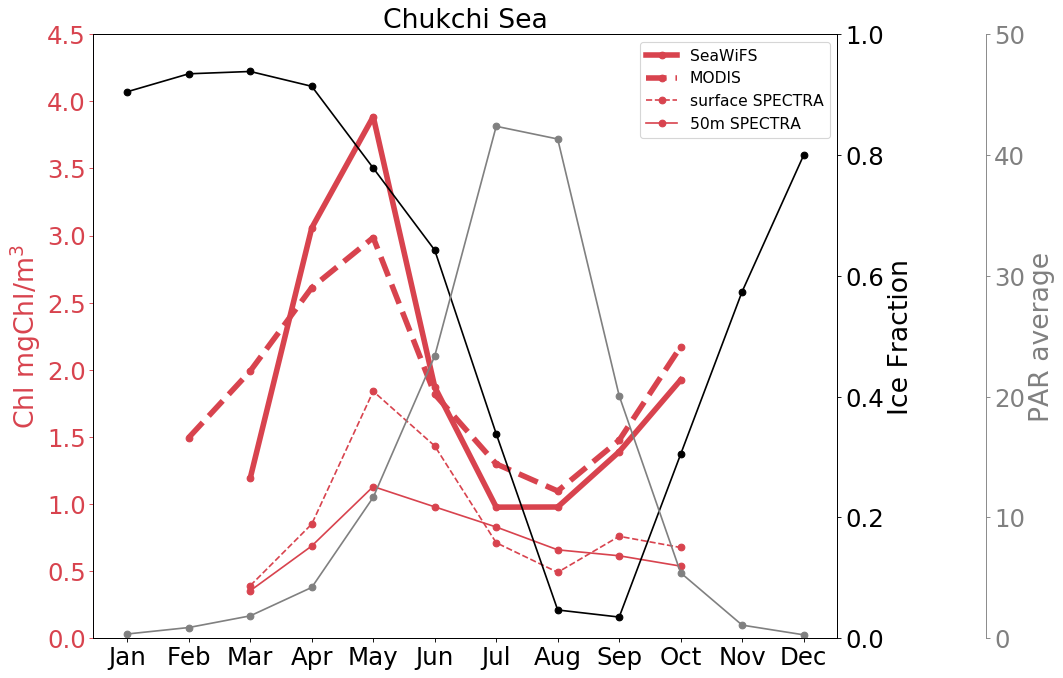

In [31]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_cs, '-o', color=cmap(1),linewidth = 5, label='SeaWiFS')
ax.plot(months,modis_cs, '--o', color=cmap(1),linewidth=5,label='MODIS')
ax.plot(months,model_cs, '--o', color=cmap(1),label='surface SPECTRA')
ax.plot(months,model_cs_50m, '-o', color=cmap(1),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Chukchi Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_cs,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_cs,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,4.5); ax2.set_ylim(0,1); ax3.set_ylim(0,50)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5, 3.0,3.5,4.0,4.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(1))  
ax.spines['left'].set_color(cmap(1)); ax.tick_params(axis='y', colors=cmap(1))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_SeaWIFS_MODIS_Chukchi_seasonality_remap.png', dpi=600, bbox_inches='tight')

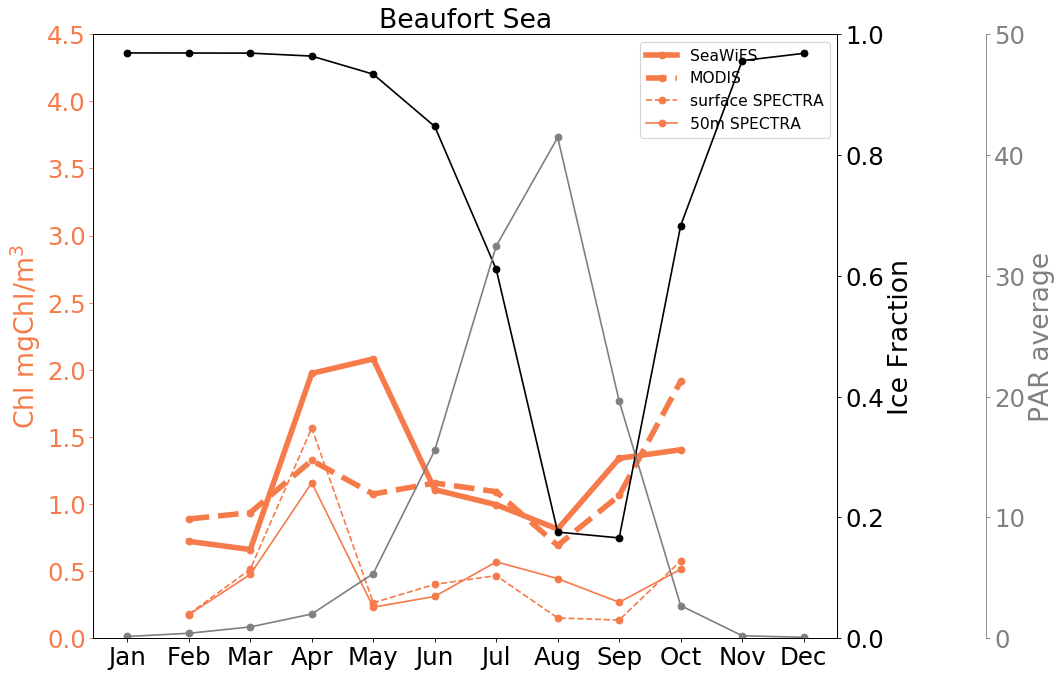

In [32]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_bs, '-o', color=cmap(2),linewidth = 5,label='SeaWiFS')
ax.plot(months,modis_bs, '--o', color=cmap(2),linewidth=5,label='MODIS')
ax.plot(months,model_bs, '--o', color=cmap(2),label='surface SPECTRA')
ax.plot(months,model_bs_50m, '-o', color=cmap(2),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Beaufort Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_bs,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bs,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,4.5); ax2.set_ylim(0,1); ax3.set_ylim(0,50)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5, 3.0,3.5,4.0,4.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(2))  
ax.spines['left'].set_color(cmap(2)); ax.tick_params(axis='y', colors=cmap(2))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_SeaWIFS_MODIS_Beaufort_seasonality_remap.png', dpi=600, bbox_inches='tight')

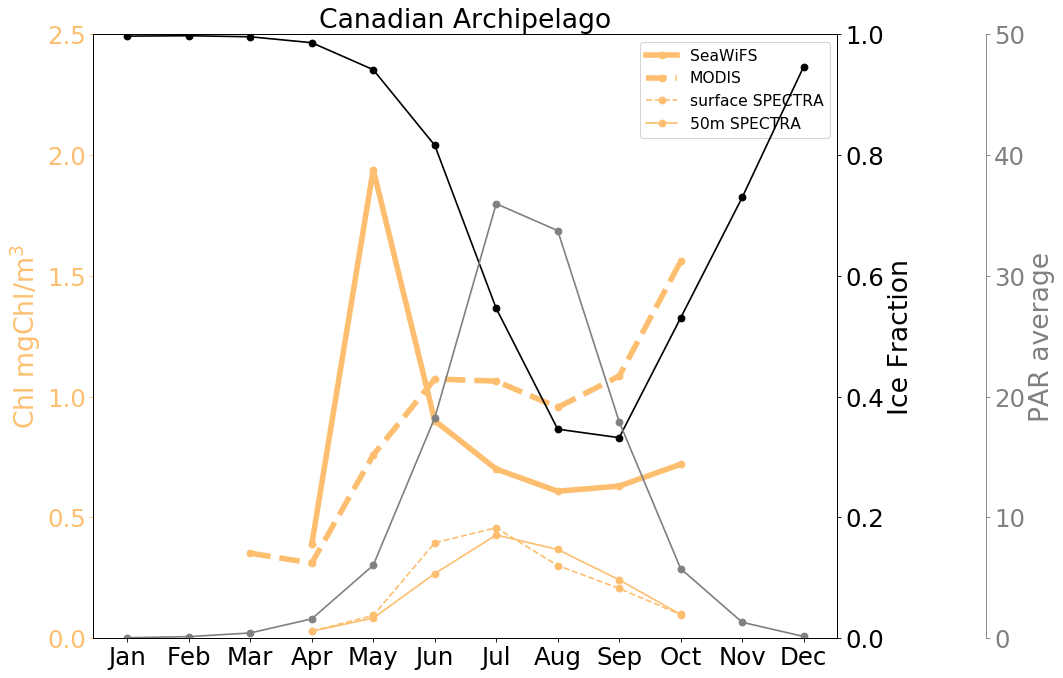

In [33]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ca, '-o', color=cmap(3),linewidth = 5,label='SeaWiFS')
ax.plot(months,modis_ca, '--o', color=cmap(3),linewidth=5,label='MODIS')
ax.plot(months,model_ca, '--o', color=cmap(3),label='surface SPECTRA')
ax.plot(months,model_ca_50m, '-o', color=cmap(3),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Canadian Archipelago', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ca,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ca,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,2.5); ax2.set_ylim(0,1); ax3.set_ylim(0,50)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(3))  
ax.spines['left'].set_color(cmap(3)); ax.tick_params(axis='y', colors=cmap(3))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_SeaWIFS_MODIS_nadian_seasonality_remap.png', dpi=600, bbox_inches='tight')

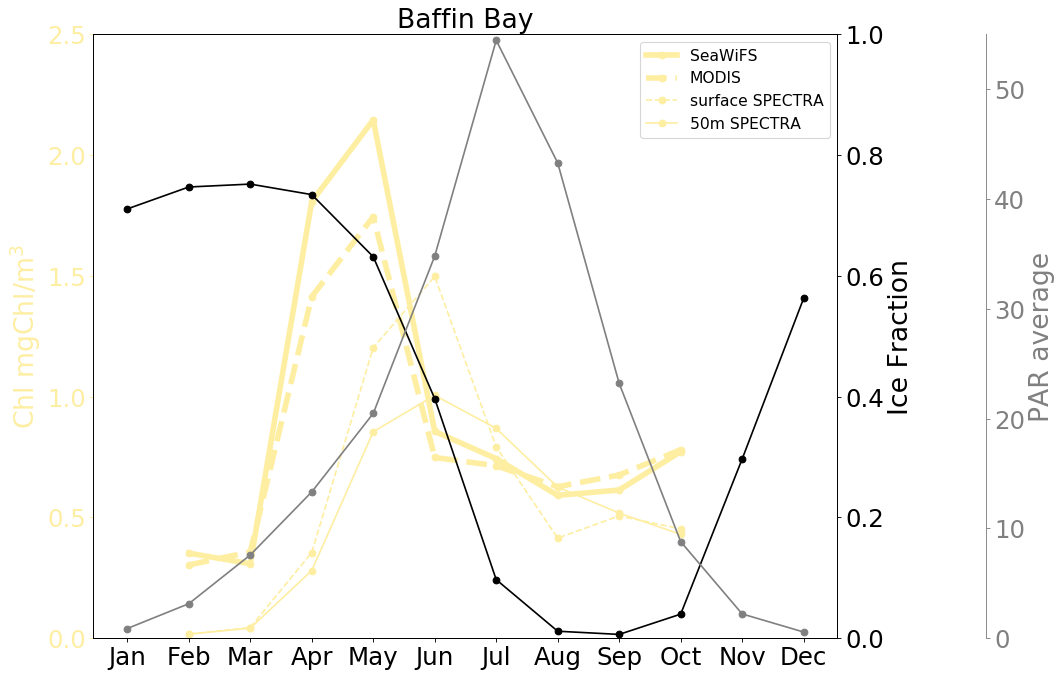

In [34]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_bb, '-o', color=cmap(4),linewidth = 5,label='SeaWiFS')
ax.plot(months,modis_bb, '--o', color=cmap(4),linewidth=5,label='MODIS')
ax.plot(months,model_bb, '--o', color=cmap(4),label='surface SPECTRA')
ax.plot(months,model_bb_50m, '-o', color=cmap(4),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Baffin Bay', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_bb,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bb,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,2.5); ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(4))  
ax.spines['left'].set_color(cmap(4)); ax.tick_params(axis='y', colors=cmap(4))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_SeaWIFS_MODIS_Baffin_seasonality_remap.png', dpi=600, bbox_inches='tight')

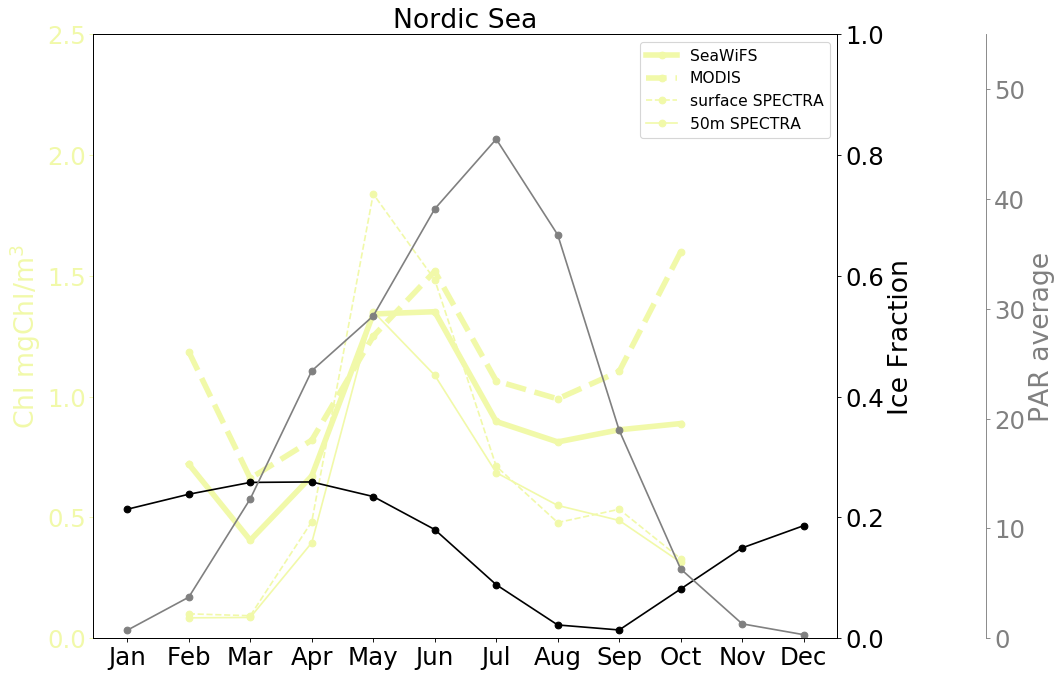

In [35]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ns, '-o', color=cmap(5),linewidth = 5,label='SeaWiFS')
ax.plot(months,modis_ns, '--o', color=cmap(5),linewidth=5,label='MODIS')
ax.plot(months,model_ns, '--o', color=cmap(5),label='surface SPECTRA')
ax.plot(months,model_ns_50m, '-o', color=cmap(5),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Nordic Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ns,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ns,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,2.5); ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(5))  
ax.spines['left'].set_color(cmap(5)); ax.tick_params(axis='y', colors=cmap(5))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_SeaWIFS_MODIS_ordic_seasonality_remap.png', dpi=600, bbox_inches='tight')

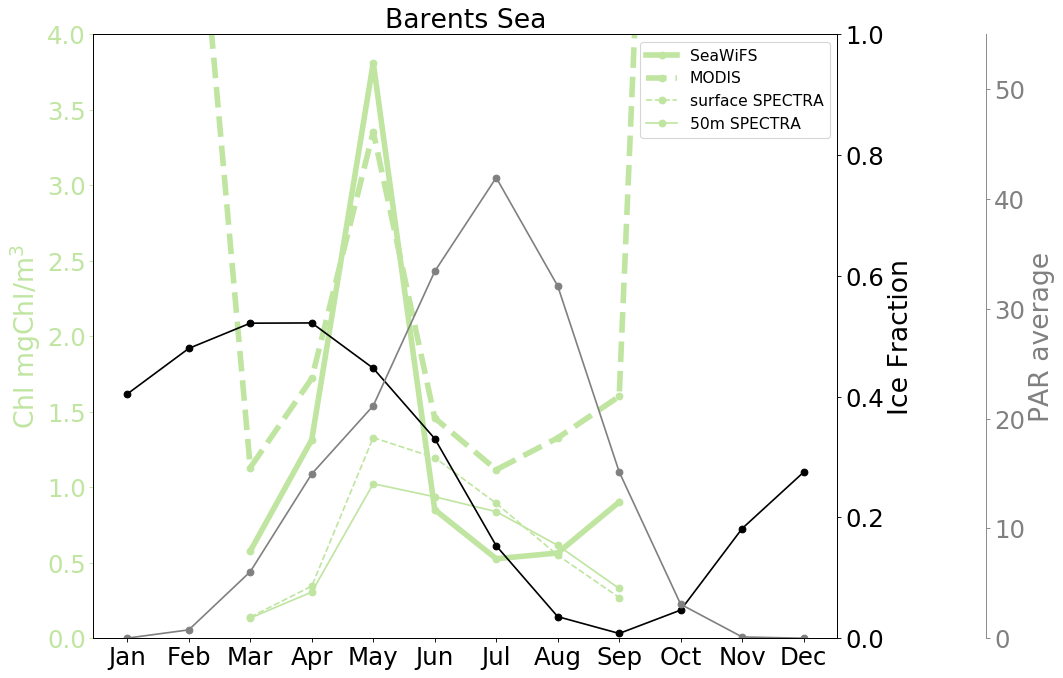

In [36]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_bts, '-o', color=cmap(6),linewidth = 5,label='SeaWiFS')
ax.plot(months,modis_bts, '--o', color=cmap(6),linewidth=5,label='MODIS')
ax.plot(months,model_bts, '--o', color=cmap(6),label='surface SPECTRA')
ax.plot(months,model_bts_50m, '-o', color=cmap(6),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Barents Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_bts,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bts,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,4.0); ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(6))  
ax.spines['left'].set_color(cmap(6)); ax.tick_params(axis='y', colors=cmap(6))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_SeaWIFS_MODIS_Barents_seasonality_remap.png', dpi=600, bbox_inches='tight')

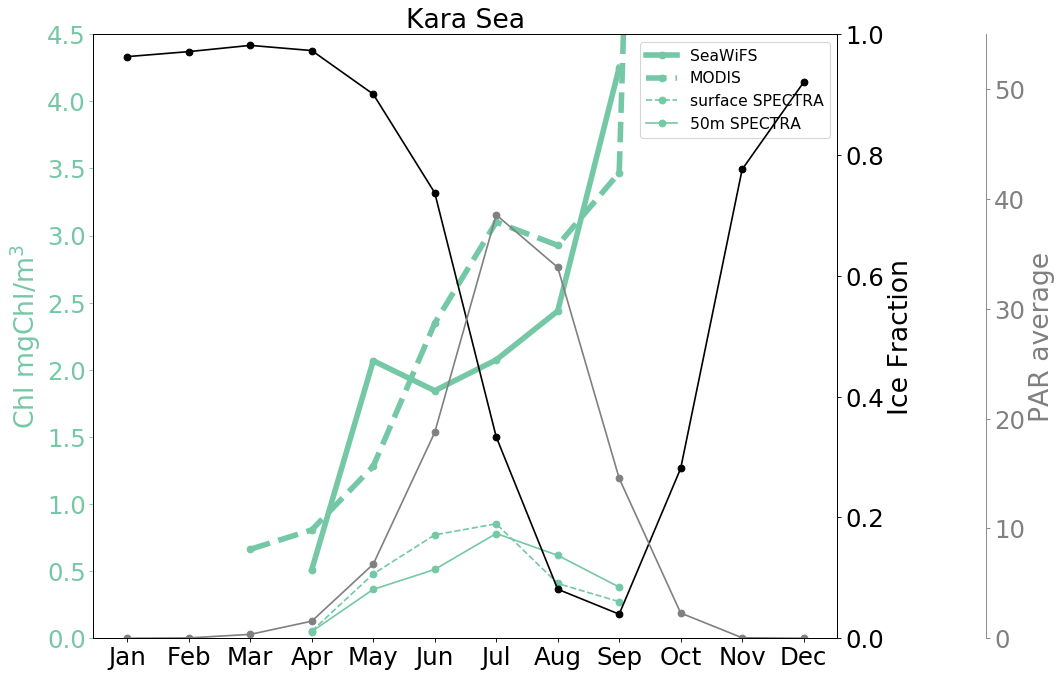

In [37]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ks, '-o', color=cmap(7),linewidth = 5,label='SeaWiFS')
ax.plot(months,modis_ks, '--o', color=cmap(7),linewidth=5,label='MODIS')
ax.plot(months,model_ks, '--o', color=cmap(7),label='surface SPECTRA')
ax.plot(months,model_ks_50m, '-o', color=cmap(7),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Kara Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ks,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ks,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,4.5); ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(7))  
ax.spines['left'].set_color(cmap(7)); ax.tick_params(axis='y', colors=cmap(7))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_SeaWIFS_MODIS_Kara_seasonality_remap.png', dpi=600, bbox_inches='tight')

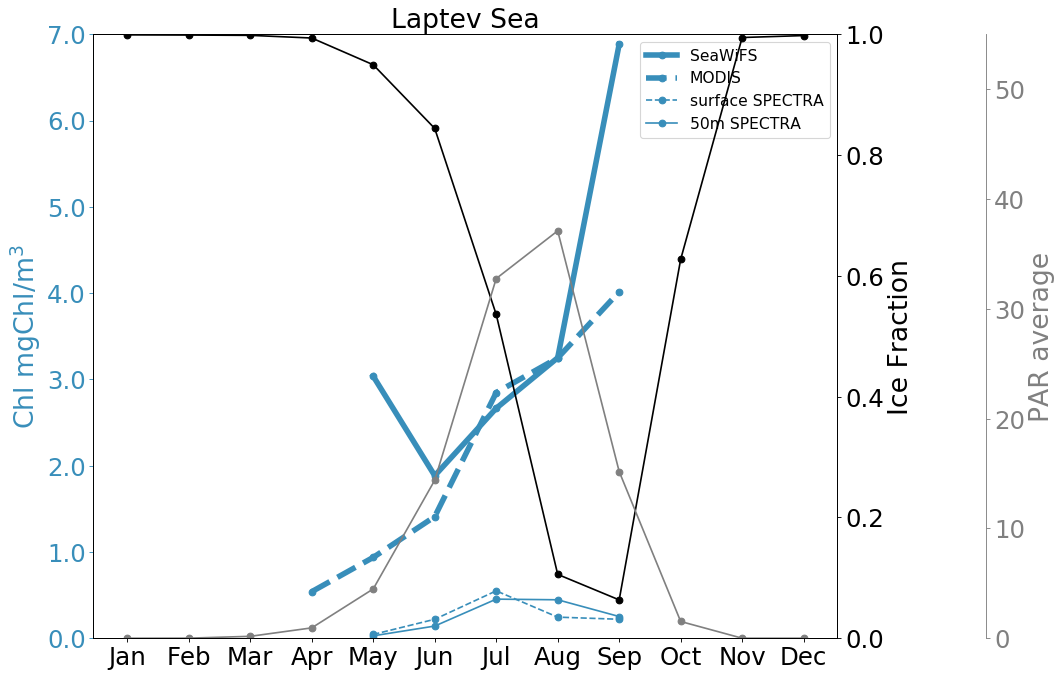

In [39]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ls, '-o', color=cmap(8),linewidth = 5,label='SeaWiFS')
ax.plot(months,modis_ls, '--o', color=cmap(8),linewidth=5,label='MODIS')
ax.plot(months,model_ls, '--o', color=cmap(8),label='surface SPECTRA')
ax.plot(months,model_ls_50m, '-o', color=cmap(8),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Laptev Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ls,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ls,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,7.0); ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax.set_yticklabels([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(8))  
ax.spines['left'].set_color(cmap(8)); ax.tick_params(axis='y', colors=cmap(8))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_SeaWIFS_MODIS_Laptev_seasonality_remap.png', dpi=600, bbox_inches='tight')

## Now compare blooms in the North Atlantic
I am thinking (60N-45N), and (40W and 8W), but this is just a small seciton of the North Atlantic, but decided to use the same latitude range as nordic sea, but just 20 degrees lower in latitude! 

In [18]:
diat1_ds.lon[155:205]

<xarray.DataArray 'lon' (lon: 50)>
array([-25., -24., -23., -22., -21., -20., -19., -18., -17., -16., -15., -14.,
       -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,
        -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.])
Coordinates:
  * lon      (lon) float64 -25.0 -24.0 -23.0 -22.0 -21.0 ... 21.0 22.0 23.0 24.0
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X

In [21]:
diat1_ds.lat[129:149]

<xarray.DataArray 'lat' (lat: 20)>
array([39.5, 40.5, 41.5, 42.5, 43.5, 44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5,
       51.5, 52.5, 53.5, 54.5, 55.5, 56.5, 57.5, 58.5])
Coordinates:
  * lat      (lat) float64 39.5 40.5 41.5 42.5 43.5 ... 54.5 55.5 56.5 57.5 58.5
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y

In [22]:
# Model Chlorophyll for every region (surface)
model_na = np.nanmean(phytoChl_surface[:,129:149,155:205], axis=(1,2))

# Top 50 meters
model_na_50m = np.nanmean(phytoChl_50m[:,129:149,155:205], axis=(1,2))

# Observed Chlorophyll for every region. 
obs_na = np.nanmean(obss.chl_ocx[:,129:149,155:205], axis=(1,2))

# MODIS Aqua chlorophyll 
modis_na = np.nanmean(obss_MODIS.chl_ocx[:,129:149,155:205], axis=(1,2))

# Modeling the PAR average 
PAR_na = np.nanmean(PAR_ds.PAR_avg[:,0,129:149,155:205], axis=(1,2))

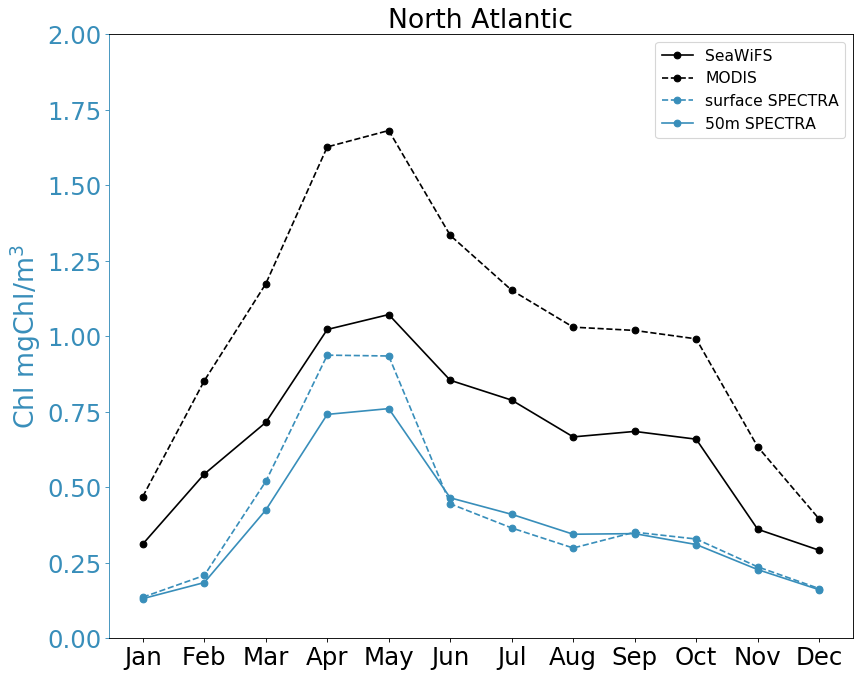

In [34]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_na, '-o', color='k',label='SeaWiFS')
ax.plot(months,modis_na, '--o', color='k',label='MODIS')
ax.plot(months,model_na, '--o', color=cmap(8),label='surface SPECTRA')
ax.plot(months,model_na_50m, '-o', color=cmap(8),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('North Atlantic', fontsize=24)
#ax3 = ax.twinx();
#ax3.plot(months, PAR_na,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,2); ax2.set_ylim(0,1); ax3.set_ylim(0,80)
#ax.set_yticklabels([0.0,1.0,2.0,3.0,4.0],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(8))  
ax.spines['left'].set_color(cmap(8)); ax.tick_params(axis='y', colors=cmap(8))  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_SeaWIFS_MODIS_NA_seasonality_remap.png', dpi=600, bbox_inches='tight')